## Setting

In [10]:
import import_ipynb
import os, timm, cv2 
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from itertools import combinations
from model_load import *
from dataloader import *
import warnings
warnings.filterwarnings('ignore')

In [11]:
class CustomDataset(Dataset):
    def __init__(self, path, transforms = None):
        
        self.path = path
        keys = list(set([x.split('/')[-2] for x in self.path]))
        keys.sort()
        dictkeys = {key:idx for idx, key in enumerate(keys)}
        self.label = [dictkeys[i.split('/')[-2]] for i in self.path]       
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        path = self.path[index]
        data = cv2.imread(path, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            data = self.transforms(data)
        
        return data, self.label[index]
    
    def __len__(self):
        return len(self.path)

In [22]:
def test(model, test_loader, name):
    model.eval()
    model.cuda()
    aa = torch.Tensor()
    bb = torch.Tensor()

    with torch.no_grad():
        for img, ll in test_loader:
            img, ll = img.cuda(), ll
            if name == 'seresnext101_32x4d':
                pred = model(img)[:,:10].cpu()
            else:
                pred = model(img).cpu()
            pred = F.softmax(pred)
            aa = torch.cat([aa, pred])
            bb = torch.cat([bb, ll])
  
    return aa.cpu(), bb.cpu()

In [23]:
def ensemble(model_name, test_loader):
    model_pred = []
    label = []
    for i in tqdm(model_name):
        if i in ['resnet50', 'efficientnet_b0', 'efficientnetv2_rw_s']:
            model = model_load(i, pre = False, num=10)
            check = torch.load(os.path.join('./parameter', i+'.pth'))['model_state_dict']
            model.load_state_dict(check)
        elif i in 'seresnext101_32x4d':
            model = model_load(i, pre = False, num=192)
            model.relu = nn.ReLU(True)
            model.fc2 = nn.Linear(192,10)
            check = torch.load(os.path.join('./parameter', i+'.pth'))
            model.load_state_dict(check)
        else:
            model = model_load(i, pre = False, num=10)
            check = torch.load(os.path.join('./parameter', i+'.pth'))
            model.load_state_dict(check)

        model_pred.append(test(model, test_loader, i)[0].tolist())
        label.append(test(model, test_loader, i)[1].tolist())

    pred = torch.Tensor(model_pred)
    label = torch.Tensor(label)[0]

    pred = pred.sum(axis=0)
    final_pred = pred.argmax(dim = 1)

    arr = confusion_matrix(final_pred, label)
    score = accuracy_score(final_pred, label)
    
    return arr, score

## Test

In [24]:
path = glob('/data/deeplearning/test_image/*/*/*')

In [25]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224]),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [27]:
dataset = CustomDataset(path, transform)
test_loader = DataLoader(dataset, 128, shuffle=False, num_workers=4)

In [28]:
model_name = ['seresnext101_32x4d','efficientnet_lite2', 'res2net50_26w_8s', 'efficientnetv2_rw_s', 'efficientnet_b0']

In [29]:
arr, score = ensemble(model_name, test_loader)

100%|██████████| 5/5 [00:49<00:00,  9.95s/it]


In [30]:
keys = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [31]:
cf_pd = pd.DataFrame(arr, index = keys, columns = keys)

Text(0.5, 1.0, 'Ensemble Confusion Matrix')

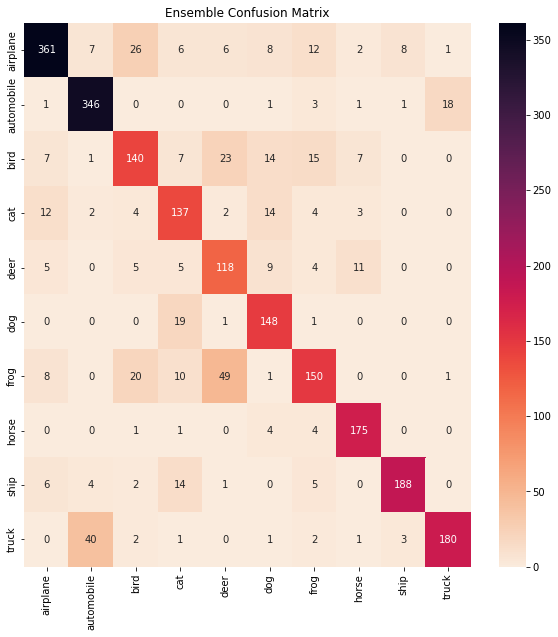

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(cf_pd, annot = True, fmt = 'd', cmap = 'rocket_r', xticklabels = keys, yticklabels = keys)
plt.title('Ensemble Confusion Matrix')

In [33]:
score

0.8095833333333333